In [40]:
import pandas as pd

In [41]:
import pandas as pd

# === Load CSV files ===
huggingface_path = r"C:\Users\mloai\Sentimental_Analysis_App\Notebooks\reviews_with_sentiment.csv"
gemini_path = r"C:\Users\mloai\gemini_sentiment_output.csv"

# Load and restrict to first 443 rows
hf_df = pd.read_csv(huggingface_path).head(443)
gemini_df = pd.read_csv(gemini_path).head(443)

# === Rename columns for clarity ===
hf_df = hf_df.rename(columns={"SENTIMENT": "SENTIMENT_HF"})
gemini_df = gemini_df.rename(columns={"SENTIMENT": "SENTIMENT_GEMINI"})

# === Merge on CLEAN_ANSWER ===
merged = pd.merge(
    hf_df[['CLEAN_ANSWER', 'SENTIMENT_HF']],
    gemini_df[['CLEAN_ANSWER', 'SENTIMENT_GEMINI']],
    on="CLEAN_ANSWER",
    how="inner"
)

# === Neutral keywords to remove ===
neutral_keywords = {
    # Arabic
    "لا", "لا يوجد", "لا شي", "لايوجد","لا شيء", "مافي", "ولا شي", "ولا شيء", "ما في",
    # English
    "none", "nothing", "no", "n/a", "not applicable", "ok", "okay", "noted",
    "received", "confirmed", "yes", "done", "fine","Na","No"
}
# === Filter out rows where CLEAN_ANSWER is exactly one of the neutral keywords ===
merged = merged[~merged['CLEAN_ANSWER'].str.strip().isin(neutral_keywords)]

# === Compare sentiment predictions ===
merged["MATCH"] = merged["SENTIMENT_HF"] == merged["SENTIMENT_GEMINI"]

# === Compute comparison stats ===
total = len(merged)
matches = merged["MATCH"].sum()
accuracy = (matches / total) * 100 if total else 0

print(f"✅ Match Count: {matches} / {total} rows")
print(f"📊 Accuracy: {accuracy:.2f}%")

✅ Match Count: 471 / 605 rows
📊 Accuracy: 77.85%


In [42]:

mismatches = merged[~merged["MATCH"]]
print("\n🧐 First 10 Mismatches:")
print(mismatches.head(10))


🧐 First 10 Mismatches:
                                         CLEAN_ANSWER SENTIMENT_HF  \
1   اقترح في موضوع النوصيل المنزلي أن تتعاونوا مع ...      Neutral   
2   إعطاء ثقة تامه إذا رغب العميل باخد خدمة الصيان...     Negative   
5                              Availability  of stock     Positive   
9   base from my experience.. there should a choic...     Positive   
11                                              Onest     Positive   
25                More discounts for loyal customers.     Negative   
27              Tell customers exactly about products     Positive   
28                                 خفض اسعار المنتجات     Negative   
33  الخدمه للاسف سيئه ما احد يرد علي جوال خدمه الع...     Positive   
35                                     سرعة الرد حلوه     Negative   

   SENTIMENT_GEMINI  MATCH  
1          Negative  False  
2          Positive  False  
5           Neutral  False  
9          Negative  False  
11          Neutral  False  
25         Positive  False  
27

In [43]:

mismatches.to_csv(r"C:\Users\mloai\Sentimental_Analysis_App\mismatched_sentiments.csv", index=False, encoding='utf-8-sig')
print("💾 Mismatches saved to 'mismatched_sentiments.csv'")

💾 Mismatches saved to 'mismatched_sentiments.csv'


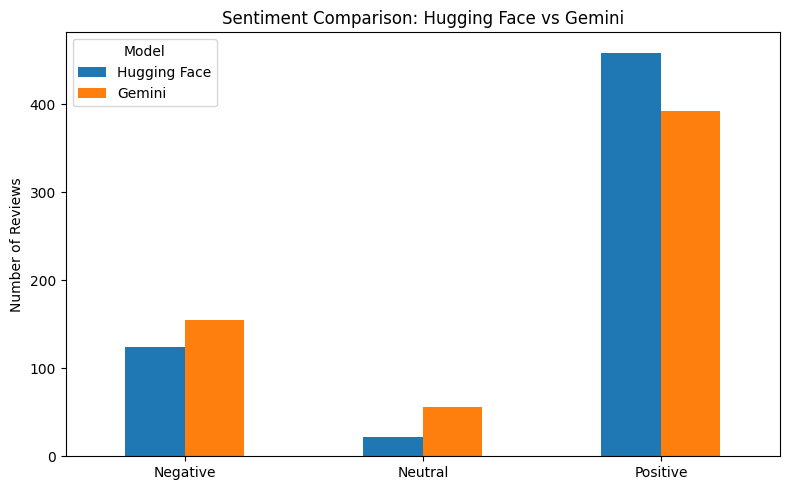

In [50]:
import pandas as pd
import matplotlib.pyplot as plt



# === Count sentiment distributions ===
hf_counts = merged['SENTIMENT_HF'].value_counts()
gm_counts = merged['SENTIMENT_GEMINI'].value_counts()

# === Create DataFrame for plotting ===
compare_df = pd.DataFrame({
    'Hugging Face': hf_counts,
    'Gemini': gm_counts
}).fillna(0)

# Ensure consistent order
sentiment_order = ['Negative', 'Neutral', 'Positive']
compare_df = compare_df.reindex(sentiment_order)

# === Plot ===
compare_df.plot(kind='bar', figsize=(8, 5), color=['#1f77b4', '#ff7f0e'])
plt.title('Sentiment Comparison: Hugging Face vs Gemini')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

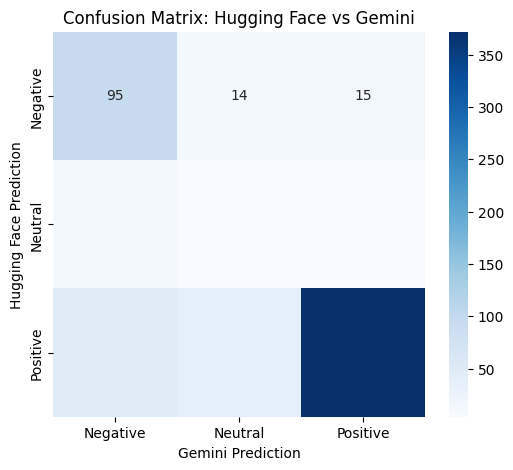

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(
    merged['SENTIMENT_HF_SIMPLE'],
    merged['SENTIMENT_GEMINI_SIMPLE'],
    labels=["Negative", "Neutral", "Positive"]
)

# Plot heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix: Hugging Face vs Gemini")
plt.xlabel("Gemini Prediction")
plt.ylabel("Hugging Face Prediction")
plt.show()


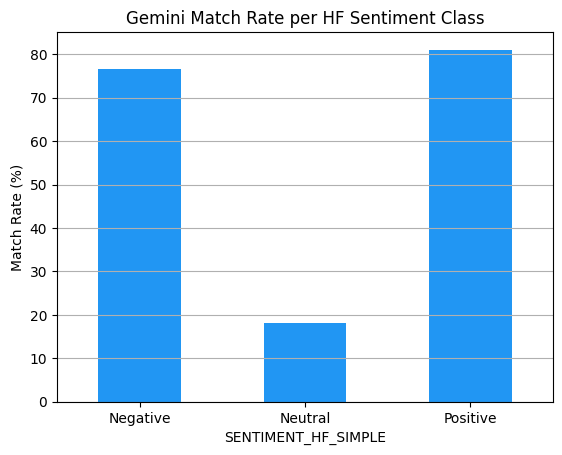

In [47]:
match_df = merged.copy()
match_df['MATCH'] = match_df['SENTIMENT_HF_SIMPLE'] == match_df['SENTIMENT_GEMINI_SIMPLE']

match_rate = match_df.groupby('SENTIMENT_HF_SIMPLE')['MATCH'].mean() * 100

# Plot
match_rate.plot(kind='bar', color='#2196F3')
plt.ylabel('Match Rate (%)')
plt.title('Gemini Match Rate per HF Sentiment Class')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


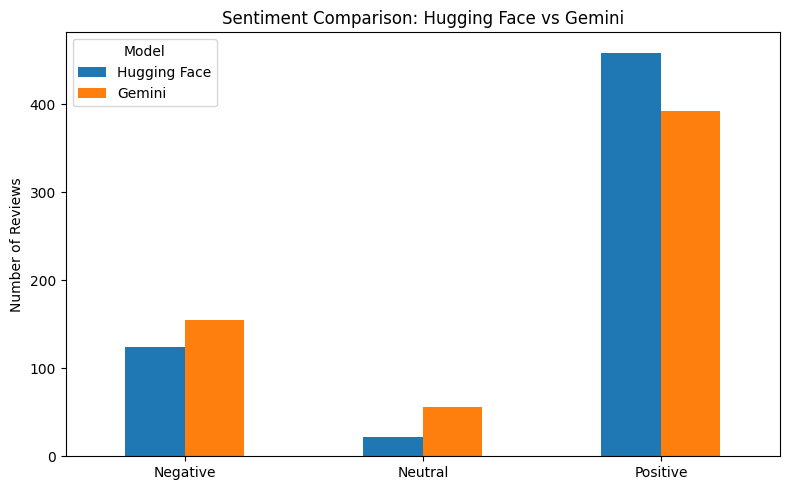